# Задача
- Запустите A/A-тест
- Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
- Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
- Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [23]:
# Read df
df = pd.read_csv('/Users/user/Downloads/hw_aa.csv', sep = ';').iloc[:,1:]

In [24]:
df

,uid,experimentVariant,version,purchase
0,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127013,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [11]:
# Describe our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.9+ MB


#### Запустим AA test для 2 вариантов эксперимента

  0%|          | 0/1000 [00:00<?, ?it/s]

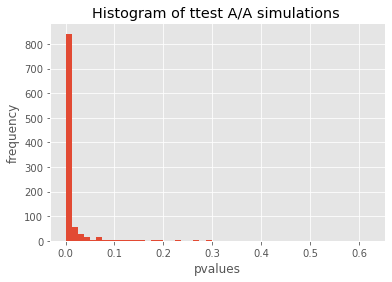

0.943

In [39]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant==0').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant==1').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

p-value > 0.943, значит наши 2 варианта эксперимента отличаются друг от друга. 
Попробуем посчитать конверсии и понять, в какой версии у нас случилась поломка


In [40]:
# Calculate purchase conversion by version and experimentVariant
df1 = df.groupby(['version','experimentVariant'], as_index = False)['purchase'].mean()
df1

,version,experimentVariant,purchase
0,v2.8.0,0,0.000993
1,v2.8.0,1,0.045606
2,v2.9.0,0,0.074658
3,v2.9.0,1,0.071304
4,v3.7.4.0,0,0.059943
5,v3.7.4.0,1,0.063018
6,v3.8.0.0,0,0.057604
7,v3.8.0.0,1,0.062848


In [51]:
df2 = df1.pivot_table(df1, index = 'version', columns = 'experimentVariant').reset_index()
df2

version  purchase          
experimentVariant                   0         1
0                    v2.8.0  0.000993  0.045606
1                    v2.9.0  0.074658  0.071304
2                  v3.7.4.0  0.059943  0.063018
3                  v3.8.0.0  0.057604  0.062848

Мы видим, что наиболее сильные различия между вариантами эксперимента наблюдаются в версии v2.8.0. Проверим это с помощью эксперимента - запустим тест, не принимая во внимание версию v2.8.0

#### Запустим AA test для 2 вариантов эксперимента, без учета версии v2.8.0

  0%|          | 0/1000 [00:00<?, ?it/s]

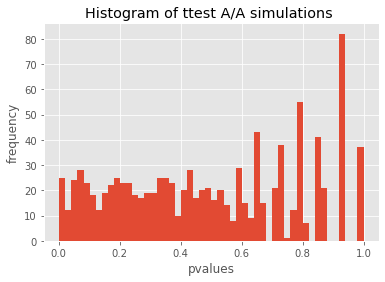

0.044

In [76]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant==0 and version!= "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant==1 and version!= "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

p-value значительно снизился и теперь он менее 0.044, значит проблема в версии v2.8.0. Запустим A/A тест для этой версии

#### Запустим AA test для 2 вариантов эксперимента и версии v2.8.0

  0%|          | 0/1000 [00:00<?, ?it/s]

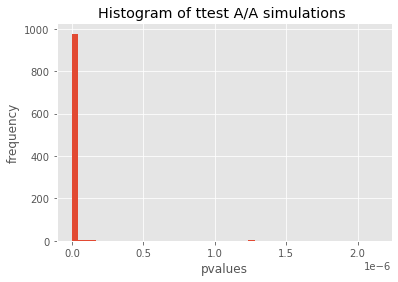

1.0

In [74]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant==0 and version == "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant==1 and version == "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Тест показал, что p-value = 1, что доказывает наличие проблем в версии v2.8.0

Найдем p-value для остальных версий

#### Запустим AA test для 2 вариантов эксперимента и версии v2.9.0

  0%|          | 0/1000 [00:00<?, ?it/s]

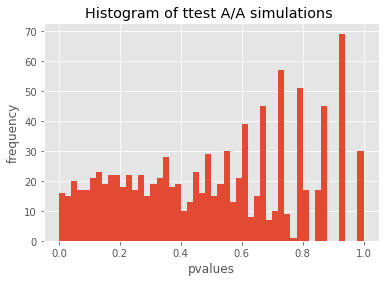

0.038

In [71]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant==0 and version == "v2.9.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant==1 and version == "v2.9.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Тест показал, что p-value < 0.05, значит проблем в версии v2.9.0 нет


#### Запустим AA test для 2 вариантов эксперимента и версии v3.7.4.0

  0%|          | 0/1000 [00:00<?, ?it/s]

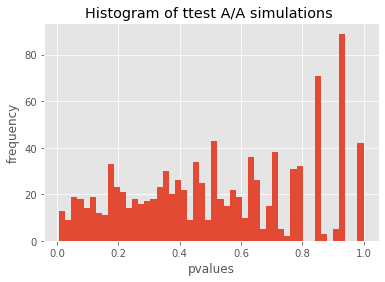

0.026

In [68]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant==0 and version == "v3.7.4.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant==1 and version == "v3.7.4.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Тест показал, что p-value < 0.05, значит в версии v3.7.4.0 проблем нет

#### Запустим AA test для 2 вариантов эксперимента и версии v3.8.0.0

  0%|          | 0/1000 [00:00<?, ?it/s]

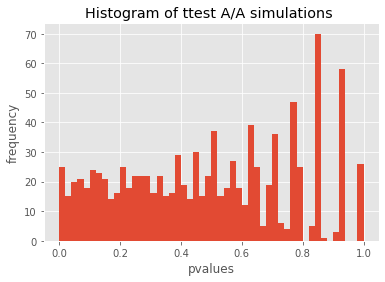

0.052

In [73]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('experimentVariant==0 and version == "v3.8.0.0"').purchase.sample(n_s, replace = False).values
    s2 = df.query('experimentVariant==1 and version == "v3.8.0.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Тест показал, что p-value немногим больше 0.05, что допустимо. Значит проблем в версии v3.8.0.0 нет


### Вывод: результат A/A теста показал наличие поломок в версии v2.8.0